![Student debt can be crushing.](student_loan_debt_2.png)

## 2.3.1 - A Sample Data Analaysis

The question we're trying to answer really boils down to a simple query: ***how do I pick thge college that's right for me and that best positions me to avoid student debt?*** To answer this, we'll embark on a three-factor analysis to investigate trends related to three key sub-questions useful for figuring out what school environment makes the most sense for you. These questions are:

1. Which states have the greatest demographic diversity?
2. How do long-term career earnings vary with total cost of school attendance (i.e., input-cost v. long-term reward)?
3. How has the (inflation-adjusted) cost of attendance for colleges and universities changed over the years?

The intended audience for this analysis is recent high school graduates and military veterans interested in going to university for the first time to complete their undergraduate education.

The data for this analysis was sourced from the TidyTuesday project, originally for their 2020-03-10 podcast episode; the original repository for TidyTuesday 2020-03-10 is available at their github repo: https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-03-10. Per TidyTuesday, the underlying data compiled by TidyTyesday for this project was sourced from several places: [1] Historical Averages: [National Center for Education Statistics](https://nces.ed.gov/fastfacts/display.asp?id=76), [2] Tuition and Fees data: [The Chronicle for Higher Education](https://www.chronicle.com/interactives/tuition-and-fees), [3] Diversity Data: [The Chronicle for Higher Education](https://www.chronicle.com/article/student-diversity-at-4-725-institutions/), and [4] Average cost-of-attendance by income bracket: tuitiontracker.org.

The data dictionary used for the dataset underlying this analysis is also available from the [TidyTuesday github repo for 2020-03-10](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-03-10/readme.md), and reconstituted here for convenience:

### Data Dictionary

#### `tuition_cost.csv`

|variable             |class     |description |
|:--------------------|:---------|:-----------|
|name                 |character |School name |
|state                |character | State name |
|state_code           |character | State Abbreviation |
|type                 |character | Type: Public, private, for-profit|
|degree_length        |character | 4 year or 2 year degree |
|room_and_board       |double    | Room and board in USD |
|in_state_tuition     |double    | Tuition for in-state residents in USD |
|in_state_total       |double    | Total cost for in-state residents in USD (sum of room & board + in state tuition) |
|out_of_state_tuition |double    | Tuition for out-of-state residents in USD|
|out_of_state_total   |double    | Total cost for in-state residents in USD (sum of room & board + out of state tuition) |

##### `tuition_income.csv`

|variable    |class     |description |
|:-----------|:---------|:-----------|
|name        |character | School name |
|state       |character | State Name |
|total_price |double    | Total price in USD |
|year        |double    | year |
|campus      |character | On or off-campus |
|net_cost    |double    | Net-cost - average actually paid after scholarship/award |
|income_lvl  |character | Income bracket |

#### `salary_potential.csv`

|variable                  |class     |description |
|:-------------------------|:---------|:-----------|
|rank                      |double    | Potential salary rank within state |
|name                      |character | Name of school |
|state_name                |character | state name |
|early_career_pay          |double    | Estimated early career pay in USD |
|mid_career_pay            |double    | Estimated mid career pay in USD |
|make_world_better_percent |double    | Percent of alumni who think they are making the world a better place |
|stem_percent              |double    | Percent of student body in STEM |

#### `historical_tuition.csv`

|variable     |class     |description |
|:------------|:---------|:-----------|
|type         |character | Type of school (All, Public, Private) |
|year         |character | Academic year |
|tuition_type |character | Tuition Type All Constant (dollar inflation adjusted), 4 year degree constant, 2 year constant, Current to year, 4 year current, 2 year current |
|tuition_cost |double    | Tuition cost in USD |

#### `diversity_school.csv`
|variable         |class     |description |
|:----------------|:---------|:-----------|
|name             |character | School name |
|total_enrollment |double    | Total enrollment of students |
|state            |character | State name |
|category         |character | Group/Racial/Gender category |
|enrollment       |double    | enrollment by category |

## The Analysis

In [ ]:
dependencies <- c("here", "readr", "dplyr", "tidyr", "lubridate", "scales",
                  "ggplot2", "stringr", "tidytext", "ggthemes", "tidytuesdayR")

# Use lapply to apply the library function to each element in the list
invisible(lapply(dependencies, library, character.only = TRUE))

# Adjust plot display size
options(repr.plot.width=20, repr.plot.height=20, units = "cm")

In [2]:
# Load previously saved data from TidyTuesday GitHub: 2020-03-10
# Source: https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-03-10

tuition_cost <- readRDS(here("data", "tuition_cost.RDS"))
tuition_income <- readRDS(here("data", "tuition_income.RDS"))
salary_potential <- readRDS(here("data", "salary_potential.RDS"))
historical_tuition <- readRDS(here("data", "historical_tuition.RDS"))
diversity_school <- readRDS(here("data", "diversity_school.RDS"))

### Factor 1: What states are the best for tertiary academic diversity?

`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.


state,race,relative_fraction
<fct>,<chr>,<dbl>
Alabama,American Indian / Alaska Native,0.0068926230
Alabama,Asian,0.0175796866
Alabama,Black,0.2702181387
Alabama,Hispanic,0.0291828794
Alabama,Native Hawaiian / Pacific Islander,0.0009094664
Alabama,Two Or More Races,0.0168601087


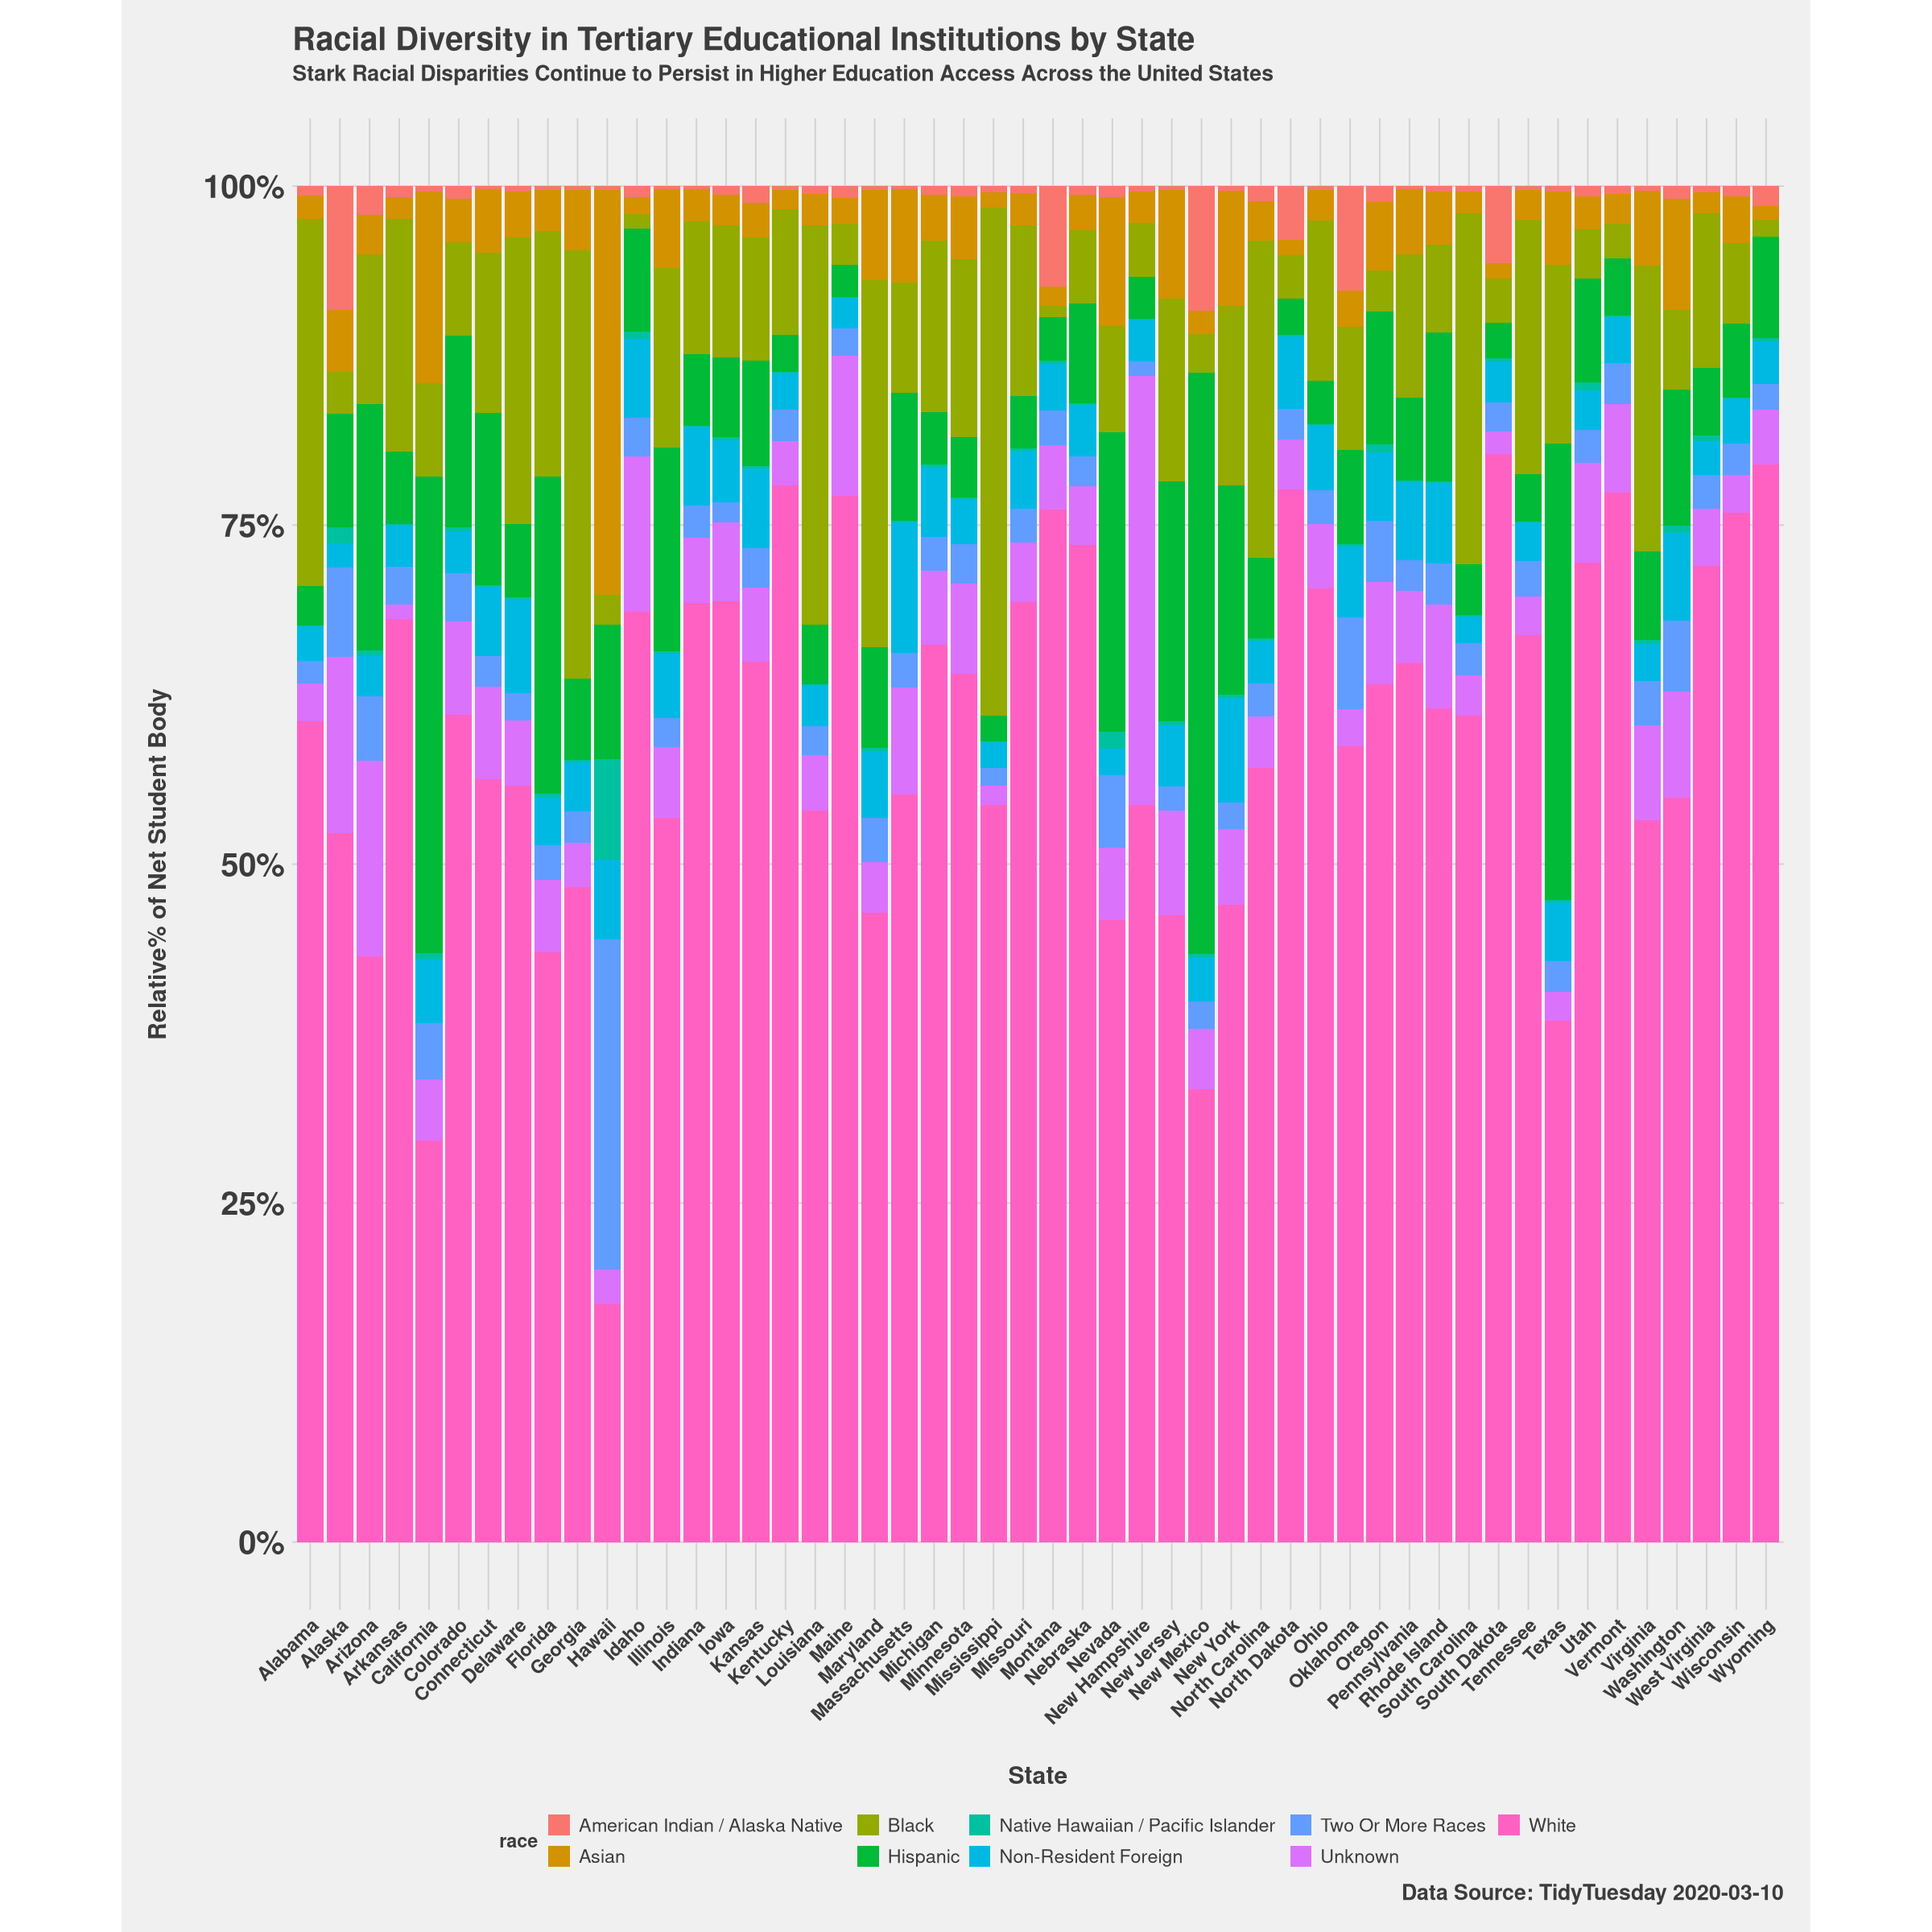

In [48]:
# PLOT 1 - Racial diversity in schools by state
# Convert all character columns to factors
diversity_update <- diversity_school %>%
    dplyr::mutate_if(is.character, as.factor)

# Diversity by state
diversity_by_state <- diversity_update %>%
    tidyr::complete(name, category, fill = list(total = 0)) %>% # ensure every combination of school and diversity category exists
    dplyr::group_by(state, category) %>%
    dplyr::summarise(total = sum(enrollment)) %>%
    tidyr::pivot_wider(names_from = category, values_from = total) %>%
    dplyr::filter(!is.na(state))

# total enrollment by state
total_enrollment_by_state <- diversity_update %>%
    dplyr::group_by(name, state) %>%
    dplyr::distinct(total_enrollment) %>%
    dplyr::group_by(state) %>%
    dplyr::summarise(total_enrollment = sum(total_enrollment))

# Merge the two dataframes
diversity_by_state <- diversity_by_state %>%
    dplyr::left_join(total_enrollment_by_state, by = "state")

# Keep columns containing racial demographic categories
cols_to_keep <- c(
  "state",
  "American Indian / Alaska Native",
  "Asian",
  "Black",
  "Hispanic",
  "Native Hawaiian / Pacific Islander",
  "Two Or More Races",
  "White",
  "Non-Resident Foreign",
  "Unknown",
  "total_enrollment"
)
diversity_by_state <- diversity_by_state %>% select(all_of(cols_to_keep))

# Calculate the percentage of each demographic category
diversity_prop <- diversity_by_state %>%
    mutate(across(`American Indian / Alaska Native`:`Unknown`, ~ . / total_enrollment, .names = "rel_{col}")) %>%
    select(state, starts_with("rel_")) %>%
    pivot_longer(cols = starts_with("rel_"), 
                 names_to = "race", 
                 values_to = "relative_fraction") %>%
    mutate(race = gsub("rel_", "", race)) # Clean up demographic names

head(diversity_prop)

ggplot(diversity_prop, aes(x = state, y = relative_fraction, fill = race)) +
  geom_bar(stat = "identity") +
  labs(title = "Racial Diversity in Tertiary Educational Institutions by State",
       subtitle = "Stark Racial Disparities Continue to Persist in Higher Education Access Across the United States",
       x = "State",
       y = "Relative% of Net Student Body",
       caption = "Data Source: TidyTuesday 2020-03-10"
       ) +

  scale_y_continuous(labels = percent_format()) + # convert y-axis to percentage

  # Use basic theme
  theme_fivethirtyeight() +
  
  # Stylize plot titles
  theme(
      axis.title.x = element_text(margin = margin(t = 25), size = 18, face = "bold"),
      axis.title.y = element_text(margin = margin(r = 25), size = 18, face = "bold"),
      plot.subtitle = element_text(size = 16, margin=margin(b=24), face = "bold"),
      plot.title = element_text(size = 24, face = "bold"),
      plot.caption = element_text(size = 16, face = "bold"),
      axis.text.x = element_text(face = "bold", size = 14, angle = 45, hjust = 1),
      axis.text.y = element_text(face = "bold", size = 24),
      legend.title = element_text(size = 14, face = "bold"),  # Change legend title size and style
      legend.text = element_text(size = 14),                  # Change legend text size
      plot.margin = margin(t = 20, r = 20, b = 20, l = 20),   # Add margin around the plot
      panel.spacing = unit(2, "lines"),                        # Add vertical spacing between facets
      aspect.ratio = 1  # Make each facet a square
  )  +
  coord_fixed(ratio = 1)  # Set overall plot to 1:1 square ratio


### Factor 2: How does cost-of-attendance relate to long-term career earnings potential?

name,total_cost
<fct>,<dbl>
Aaniiih Nakoda College,17030.00
Abilene Christian University,44355.60
Abraham Baldwin Agricultural College,14635.50
Academy College,34981.76
Academy of Art University,38655.06


rank,name,state_name,make_world_better_percent,stem_percent,total_cost_of_attendance,career_stage,avg_salary
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Auburn University,Alabama,51,31,27562.35,early_career_pay,54400
1,Auburn University,Alabama,51,31,27562.35,mid_career_pay,104500
2,University of Alabama in Huntsville,Alabama,59,45,23821.65,early_career_pay,57500
2,University of Alabama in Huntsville,Alabama,59,45,23821.65,mid_career_pay,103900
3,The University of Alabama,Alabama,50,15,27926.07,early_career_pay,52300


`geom_smooth()` using formula = 'y ~ x'


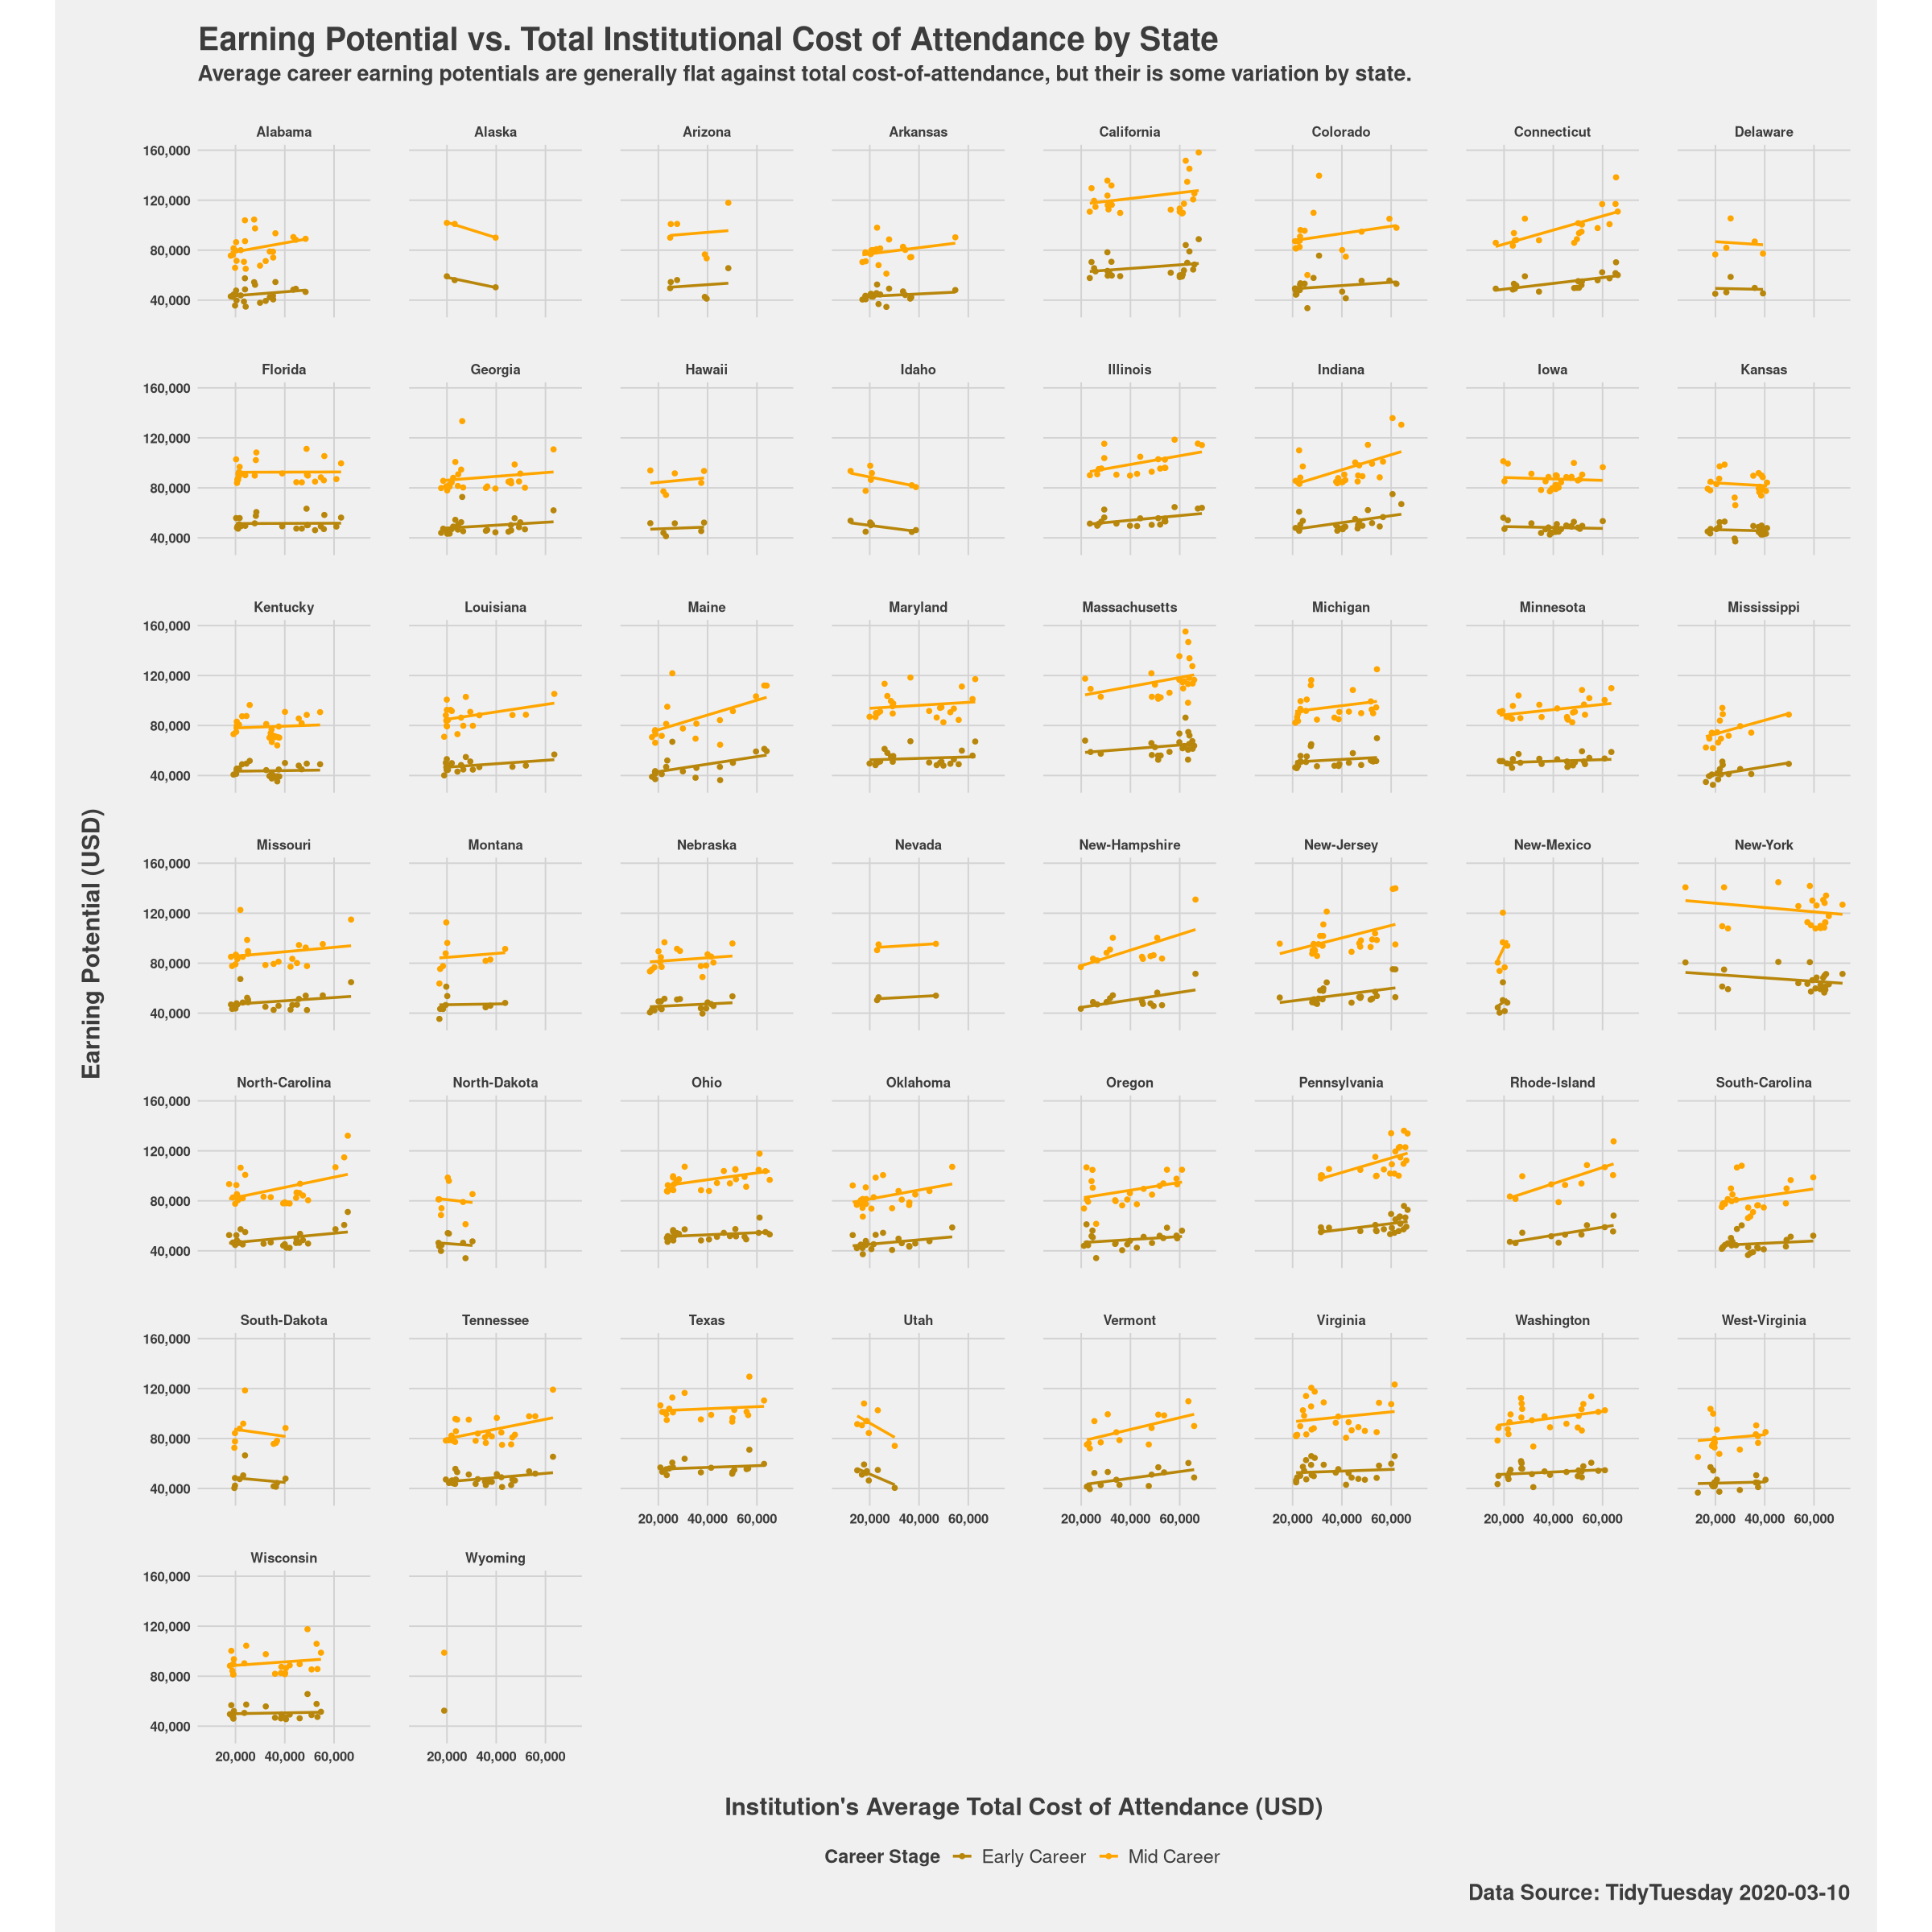

In [ ]:
# PLOT 2 - Salary vs Cost-of-Attendance by State
avg_total_cost_by_institution <- tuition_income %>%
    dplyr::mutate_if(is.character, as.factor) %>%
    dplyr::select(name, total_price) %>%
    dplyr::group_by(name) %>%
    dplyr::summarise(total_cost = mean(total_price))
head(avg_total_cost_by_institution, n = 5)

salary_by_coa <- salary_potential %>%
    dplyr::mutate_if(is.character, as.factor) %>%
    dplyr::distinct() %>%
    dplyr::left_join(avg_total_cost_by_institution, by = "name") %>% 
    dplyr::filter(!is.na(total_cost)) %>%
    dplyr::rename(total_cost_of_attendance = total_cost) %>%
    tidyr::pivot_longer(cols = c(early_career_pay, mid_career_pay), 
               names_to = "career_stage", 
               values_to = "avg_salary")
head(salary_by_coa, n = 5)

ggplot(salary_by_coa, aes(x = total_cost_of_attendance, y = avg_salary, color = career_stage)) + 
  
  geom_point() +
  
  geom_smooth(method = "lm", se = FALSE) +
  
  facet_wrap(~ state_name) +
    labs(
    title = "Earning Potential vs. Total Institutional Cost of Attendance by State",
    subtitle = "Average career earning potentials are generally flat against total cost-of-attendance, but their is some variation by state.",
    x = "Institution's Average Total Cost of Attendance (USD)",
    y = "Earning Potential (USD)",
    color = "Career Stage",
    caption = "Data Source: TidyTuesday 2020-03-10"
  ) +
  
  scale_color_manual(
    values = c("early_career_pay" = "darkgoldenrod", "mid_career_pay" = "orange"),
    labels = c("early_career_pay" = "Early Career", "mid_career_pay" = "Mid Career")
  ) +

  scale_y_continuous(labels = comma)  + # Add commas to y-axis
  scale_x_continuous(labels = comma)  + # Add commas to x-axis

  # Use basic theme
  theme_fivethirtyeight() +
  
  # Stylize plot titles
  theme(
      axis.title.x = element_text(margin = margin(t = 25), size = 18, face = "bold"),
      axis.title.y = element_text(margin = margin(r = 25), size = 18, face = "bold"),
      plot.subtitle = element_text(size = 16, margin=margin(b=24), face = "bold"),
      plot.title = element_text(size = 24, face = "bold"),
      plot.caption = element_text(size = 16, face = "bold"),
      axis.text.x = element_text(face = "bold", size = 10),
      axis.text.y = element_text(face = "bold", size = 10),
      strip.text = element_text(face = "bold", size = 10),    # Bold city names in facets
      legend.title = element_text(size = 14, face = "bold"),  # Change legend title size and style
      legend.text = element_text(size = 14),                  # Change legend text size
      plot.margin = margin(t = 20, r = 20, b = 20, l = 20),   # Add margin around the plot
      panel.spacing = unit(2, "lines"),                        # Add vertical spacing between facets
      aspect.ratio = 1  # Make each facet a square
  )  +
  coord_fixed(ratio = 1)  # Set overall plot to 1:1 square ratio

### Factor 3: How much more will my degree cost if I wait a few years to go?

type,year,tuition_type,tuition_cost
<chr>,<chr>,<chr>,<dbl>
All Institutions,1985,All Constant,10893
All Institutions,1995,All Constant,13822
All Institutions,2000,All Constant,14995
All Institutions,2001,All Constant,15497
All Institutions,2002,All Constant,16008


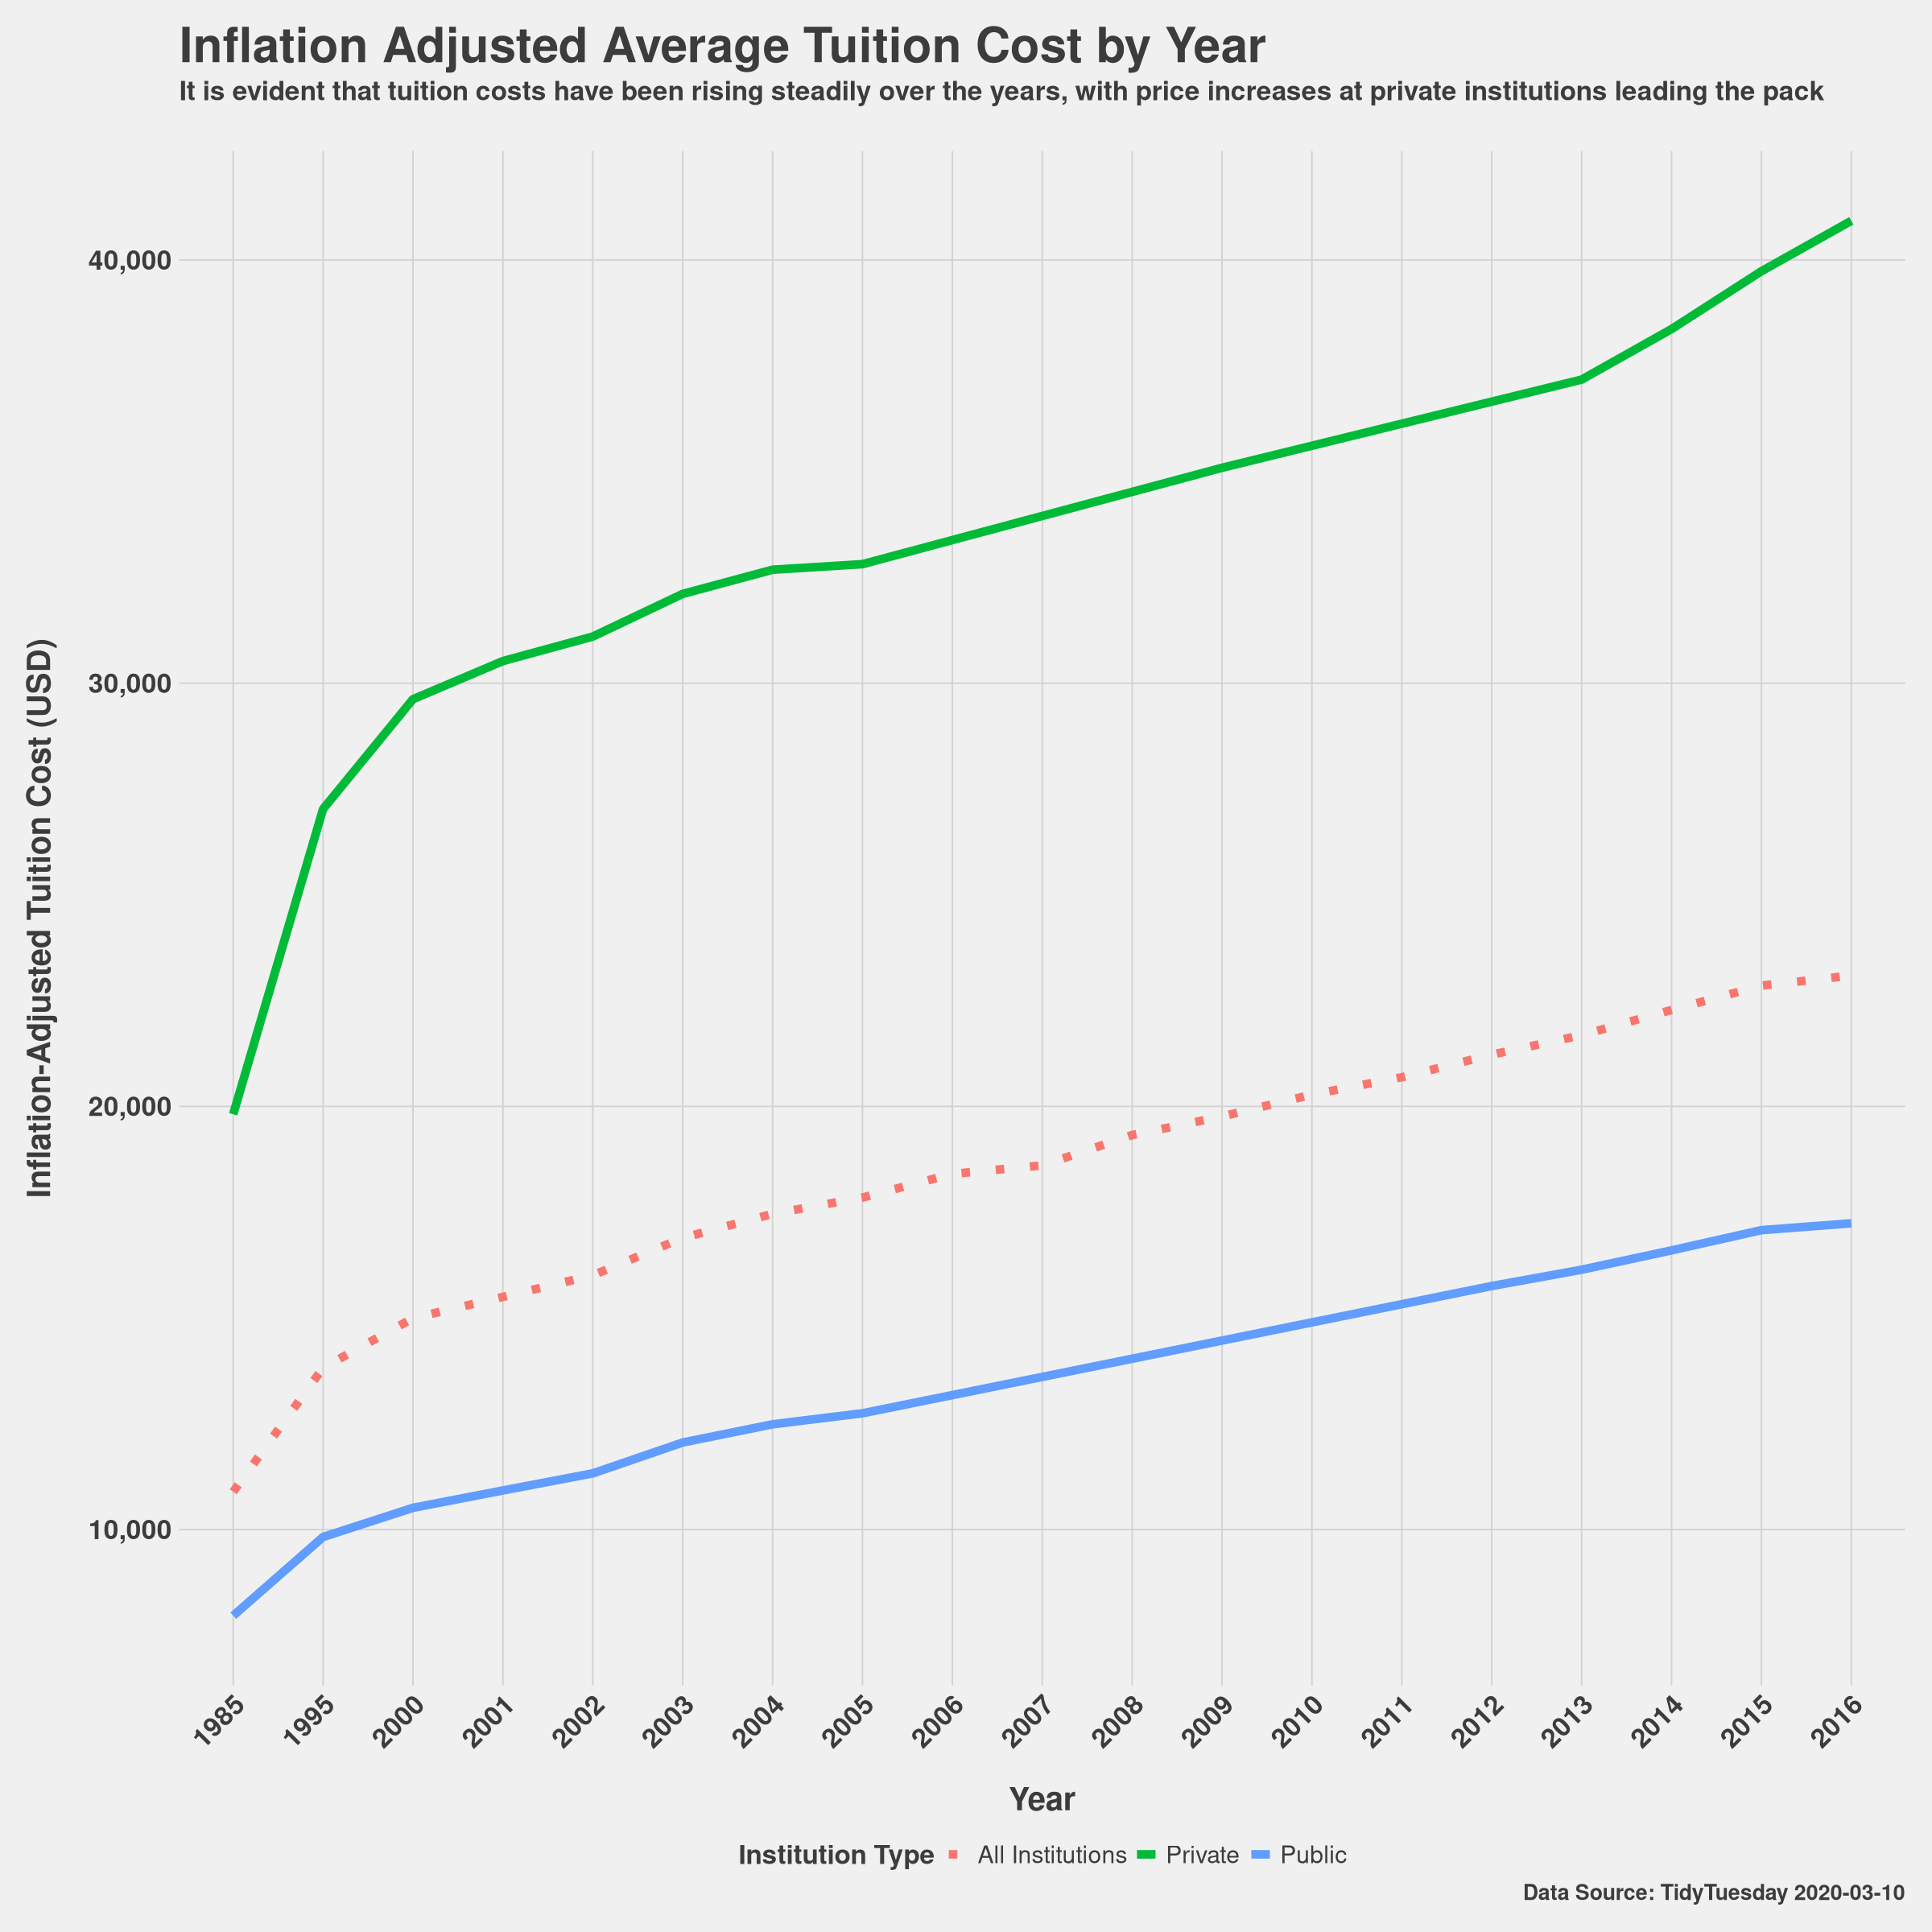

In [ ]:
# PLOT 3 
inflation_adjusted_avg_cost_by_year <- historical_tuition %>%
  dplyr::mutate(year = sub("-.*", "", year)) %>%
  dplyr::filter(tuition_type == "All Constant")

head(inflation_adjusted_avg_cost_by_year, n = 5)

# Assuming inflation_adjusted_avg_cost_by_year is your data frame
ggplot(inflation_adjusted_avg_cost_by_year, aes(x = year, y = tuition_cost, color = type, group = type)) +
  geom_line(aes(linetype = type, size = type)) +
  
  scale_linetype_manual(values = c("All Institutions" = "dotted", "Public" = "solid", "Private" = "solid")) +
  
  scale_size_manual(values = c("All Institutions" = 3, "Public" = 3, "Private" = 3)) +
  
  labs(
    title = "Inflation Adjusted Average Tuition Cost by Year",
    subtitle = "It is evident that tuition costs have been rising steadily over the years, with price increases at private institutions leading the pack",
    caption = "Data Source: TidyTuesday 2020-03-10",
    x = "Year",
    y = "Inflation-Adjusted Tuition Cost (USD)",
    color = "Institution Type",
    linetype = "Institution Type",
    size = "Institution Type"
  ) +

  scale_y_continuous(labels = comma)  + # Add commas to y-axis
  
  # Use basic theme
  theme_fivethirtyeight() +
  
  # Stylize plot titles
  theme(
      axis.title.x = element_text(margin = margin(t = 25), size = 24, face = "bold"),
      axis.title.y = element_text(margin = margin(r = 25), size = 24, face = "bold"),
      plot.subtitle = element_text(size = 20, margin=margin(b=33), face = "bold"),
      plot.title = element_text(size = 36, face = "bold"),
      plot.caption = element_text(size = 16, face = "bold"),
      axis.text.x = element_text(face = "bold", size = 20, angle = 45, hjust = 1),
      axis.text.y = element_text(face = "bold", size = 20),
      strip.text = element_text(face = "bold", size = 20),    # Bold city names in facets
      legend.title = element_text(size = 20, face = "bold"),  # Change legend title size and style
      legend.text = element_text(size = 18),                  # Change legend text size
      plot.margin = margin(t = 20, r = 20, b = 20, l = 20),   # Add margin around the plot
      panel.spacing = unit(2, "lines")                        # Add vertical spacing between facets
  )

### List of Required Functions Used for Analysis (i.e., dplyr, tidyr, ggplot2 library requirements)

1. dplyr
    * dplyr::mutate_if()
    * dplyr::select()
    * dplyr::group_by()
    * dplyr::summarise() 
    * dplyr::distinct()
    * dplyr::left_join()
    * dplyr::filter()
    * dplyr::rename()
2. tidyr
    * tidyr::complete()
    * tidyr::pivot_wider()
    * tidyr::pivot_longer()
3. ggplot2
    * ggplot2::geom_line()
    * ggplot2::geom_point()
    * ggplot2::geom_smooth()
    * ggplot2::geom_bar()